# 1 - CNN on CIFAR-10 datasets

<h2><b> Introduction: </b> </h2>
<br>
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into 64 training batches and test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

In this exercise, we'll train a CNN model to classify images into ten categories: air plane, car, bird, cat, deer, dog, frog, horse, ship and truck. These objects are illustred as following:

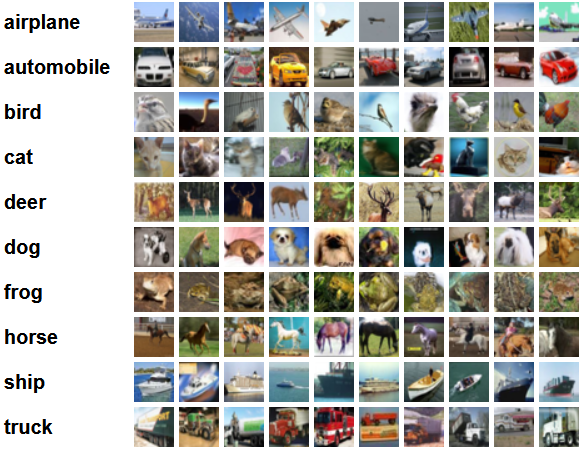


To build our model, we will, in order, import the libraries that will be used, import and describe the database, create the model and train it and evaluate the quality of the model.

## 1.1- Downloading the datasets and its description

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torchsummary import summary

The dataset is loaded from PyTorch. A transformation is applied to images during data import:
- image conversion from PIL format to PyTorch tensor
- tensor, then, as the image pixels take values between 0 and 1, a normalization was performed using the following formula:
$$
 P_{ij}{'} = \dfrac{P_{ij} - 0.5}{0.5}
$$
This standardization is important because it makes the data more suitable for learning by the CNN algorihm.

Following the code for that.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

Files already downloaded and verified


The dataset loaded above contains 50 000 images. Since we need a model validation, test and train samples, the full dataset has been divided into 3 parts (30 000 images for training the model, 10 000 images for validate the model and 10 000 images for test the model).

After this, every dataset have been loaded with a batch size 64

In [ ]:
ratio = 0.2
shuffle_dataset = True
random_seed = 42

indices = list(range(len(full_dataset)))
split = int(np.floor(0.1 * len(full_dataset)))

np.random.seed(3333)
np.random.shuffle(indices)

train_size = int(ratio * len(full_dataset))
val_size = int(ratio * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

test_indices, val_indices,  train_indices = np.split(indices, [train_size, train_size + val_size])

train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)
valid_sampler = SubsetRandomSampler(val_indices)

test_sampler, valid_sampler,train_sampler = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_sampler, batch_size=64, shuffle=True, num_workers=2)

valid_loader = torch.utils.data.DataLoader(valid_sampler, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_sampler, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

Since all the datasets is ready, let us visualize some pictures in the train set to know what is inside

In [ ]:
def show_images(images, labels):
    fig, axs = plt.subplots(1, len(images), figsize=(12, 4))
    for i in range(len(images)):
        img = images[i] / 2 + 0.5  # Unnormalize
        img = np.transpose(img.numpy(), (1, 2, 0))  # Reshape for displaying
        axs[i].imshow(img)
        axs[i].set_title(classes[labels[i]])
        axs[i].axis('off')
    plt.show()

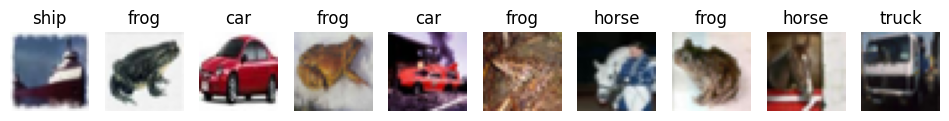

In [ ]:
data_loader = torch.utils.data.DataLoader(full_dataset, batch_size=10, shuffle=True)
dataiter = iter(data_loader)
images, labels = next(dataiter)
show_images(images, labels)

## 1.2 - Model creation et training

The datasets are ready to be modelized.
Two convolutions have been apllied and after each convolutions, we apply max poling to reduce the input data. After that, We used one hidden layer in the network with 128 neurons.

As discussed in class, the hyperparameters used in this model are:
- Number of filters: 32 for the first convolution and 64 for the second convolution
- Kernel size: 2x2
- Stride: 1
- Padding: None

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

CNN_model = Model()

The following code concern the definition of loss function et optimizer used for estimate the model. But at first, the model have been loaded on GPU to run it faster.

So, the crossEntropy have been used as loss function and Adam Optimizer for optimize the loss function

In [ ]:
CNN_model = CNN_model.to('cuda')
criterion = nn.CrossEntropyLoss()
criterion = criterion.to('cuda')
optimizer = optim.Adam(CNN_model.parameters(), lr=0.0005)

Before run the model, we have visualized the number of parameters in each step of model. Finally, our model has 545 098 parameters to estimate. The details is displayed as following:

In [ ]:
summary(CNN_model, input_size=(3, 32, 32), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
         MaxPool2d-2           [-1, 32, 16, 16]               0
            Conv2d-3           [-1, 64, 16, 16]          18,496
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Linear-5                  [-1, 128]         524,416
            Linear-6                   [-1, 10]           1,290
Total params: 545,098
Trainable params: 545,098
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.47
Params size (MB): 2.08
Estimated Total Size (MB): 2.56
----------------------------------------------------------------


The following function take a dataloader as argument, calculate and return the accuracy on this dataloader. The argument of this function can be the train dataloader, test dataloader and validation dataloader.

In [ ]:
def calculate_accuracy(dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    softmax = nn.Softmax(dim=1)
    for data in dataloader:
          images, labels = data
          images = images.to('cuda')
          labels = labels.to('cuda')
          outputs = CNN_model(images)
          probabilities = F.softmax(outputs, dim=1)
          predicted = torch.argmax(probabilities, dim=1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  accuracy = 100 * correct / total
  return accuracy

Now, the model is ready to be trained. For train it, we used 100 iterations. In each eteration we :
- get a bloc of images
- calculate loss function and save it
- Calculate accuracy on train set and save it
- Calculate accuracy on valid set and save it

The ReLU function is used as activation function in optimization step

In [ ]:
from tqdm import tqdm
CNN_model.eval()
num_epochs = 100
losses = []
accuracies_train = []
accuracies_valid = []
for epoch in tqdm(range(num_epochs), desc="Training model..."):
  running_loss = 0.0
  for i, data in enumerate(train_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to('cuda')
    labels = labels.to('cuda')
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = CNN_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  losses.append(running_loss/len(train_loader))
  acc1 = calculate_accuracy(train_loader)
  accuracies_train.append(acc1)
  acc2 = calculate_accuracy(valid_loader)
  accuracies_valid.append(acc2)

Training model...: 100%|██████████| 100/100 [34:56<00:00, 20.97s/it]


For choose an optimal value of epochs, we plot loss, accuracies for train and valid togheter to detect overtrainig.

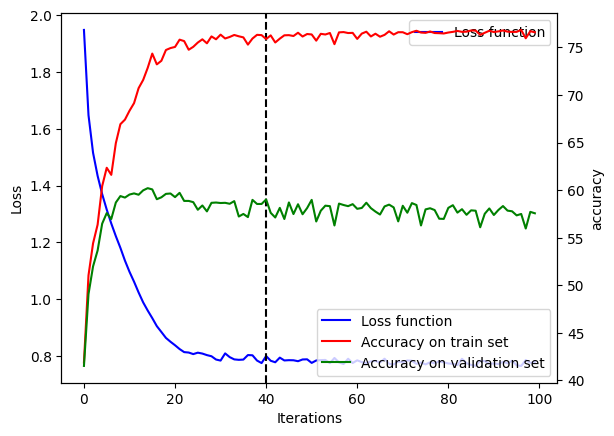

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
x = range(num_epochs)

sns.lineplot(x=x, y=losses, ax=ax1, label='Loss function', color='b')
ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')

ax2 = ax1.twinx()

sns.lineplot(x=x, y=accuracies_train, ax=ax2, label='Accuracy on train set', color='r')
sns.lineplot(x=x, y=accuracies_valid, ax=ax2, label='Accuracy on validation set', color='g')
ax2.set_ylabel('accuracy')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

ax1.axvline(x=40, color='black', linestyle='--', label='cut-off')
plt.show()

According to this figure, the optimal number of iterations is 40. Because beyond 40, loss and accuracy on the train set no longer seem to vary considerably. What's more, from this number of epochs onwards, accuracy on the valid set seems to decrease and tends to overlearn data.

So, let's train the final model with 40 iterations.

In [53]:
CNN_model.eval()
num_epochs = 40
losses2 = []
for epoch in tqdm(range(num_epochs), desc="Training model..."):
  running_loss = 0.0
  for i, data in enumerate(train_loader):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    inputs = inputs.to('cuda')
    labels = labels.to('cuda')
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward + backward + optimize
    outputs = CNN_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  losses2.append(running_loss/len(train_loader))

Training model...: 100%|██████████| 40/40 [05:44<00:00,  8.61s/it]


## 1.3 - Quality of model

Model quality is assessed only on the test set (and only once). In general, the model succeeded in predicting 64.44% of the images in this set as following.

In [54]:
accuracy = calculate_accuracy(test_loader)
print(accuracy)

56.65


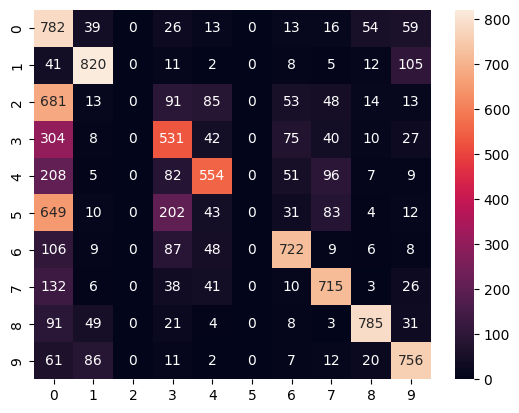

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = CNN_model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu()
        labels = labels.cpu()
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In this confusion matrix we can see that in the 8th class, None of the images in class 8 and 4 could be properly classified, unlike the other classes. High values are found on the diagonal, meaning that the model was able to predict most of the test images well.

# 2 - Input masking

In this exercise, we will realize in practice if the CNN models detect the object in images before classification. In other words, In other words, will two images of a dog in different positions produce the same output?

To do this, we'll use a pre-trained VGG16 model that classifies images into 100 classes. The main task will be to hide a few parts of an input image and compare the probabilities of this model predicting the correct result.

Let us import the required libraries

In [ ]:
import torch
import torchvision.models as models
from PIL import Image
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import datasets

Let us load pretrained VGG16 model from PyTorch

In [ ]:
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 68.7MB/s]


We will use a cat image from the web in this address: https://images.alphacoders.com/914/91401.jpg

First, we load this image, apply some transformations (resizing and normalization) before pass it in the model.

In [ ]:
from PIL import Image
import requests
from io import BytesIO

image_url = "https://images.alphacoders.com/914/91401.jpg"

response = requests.get(image_url)

if response.status_code == 200:
    image = Image.open(BytesIO(response.content))
    plt.imshow(image)
    plt.show()
else:
    print("Impossible de télécharger l'image. Code de réponse :", response.status_code)

initial_image = image.copy()

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

input_image = Variable(input_batch, requires_grad=True)


Let us predict the class of this image to be sure that the model remember this image

In [ ]:
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import json
import requests

url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
response = requests.get(url)
class_names = json.loads(response.text)

vgg16.eval()
with torch.no_grad():
    outputs = vgg16(input_image)
    _, predicted = torch.max(outputs, 1)

probs = torch.nn.functional.softmax(outputs[0], dim=0)
predicted_class = class_names[predicted.item()]
print("The probability to be a tiger cat is :"+str(probs[282].item())+" | Predicted: "+str(predicted_class))

Let us find its index

In [ ]:
for i in range(len(class_names)):
    if class_names[i] == predicted_class:
        cat_index= i
        print(i)
        exit

So, the model recognize it well. Now, let us hide the head of this cat and predict again

In [ ]:
def OccludePortion(image, x1,x2,y1,y2, color=(0,0,0,0)):
    img = image
    width, height = img.size
    for x in range(x1, x2):
        for y in range(y1,y2):
            img.putpixel((x,y), color)
    return img

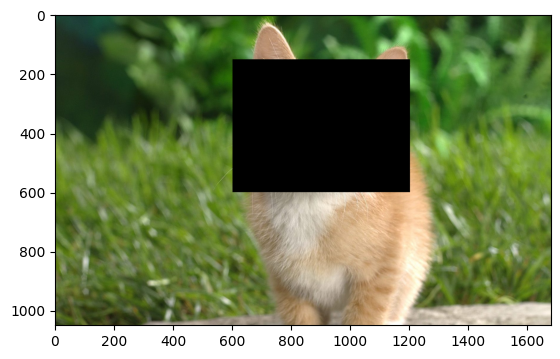

In [ ]:
img = initial_image.copy()
inpu_image2 = OccludePortion(img,600,1200,150,600,(0,0,0,0))
plt.imshow(inpu_image2)
plt.show()

In [ ]:
input_tensor = preprocess(inpu_image2)
input_batch = input_tensor.unsqueeze(0)

inpu_image2 = Variable(input_batch, requires_grad=True)

with torch.no_grad():
    outputs = vgg16(inpu_image2)
    _, predicted = torch.max(outputs, 1)

probs = torch.nn.functional.softmax(outputs[0], dim=0)
predicted_class = class_names[predicted.item()]
print("The probability to be a tiger cat is :"+str(probs[282].item())+" | Predicted: "+str(predicted_class))

We can see in this result that the probability decrease from 0.35 to 0.08

Now, Let's hide the least important part of the image, i.e. the space outside the cat. And recalculate this probability

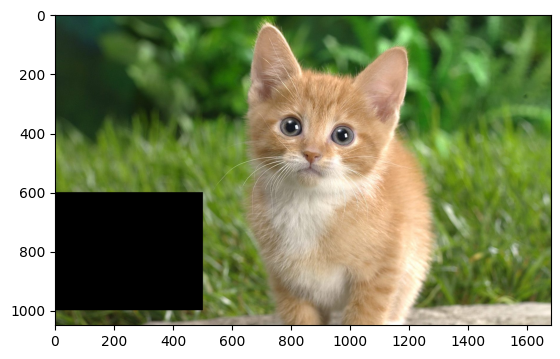

In [ ]:
img = initial_image.copy()
inpu_image3 = OccludePortion(img,0,500,600,1000,(0,0,0,0))
plt.imshow(inpu_image3)
plt.show()

In [ ]:
input_tensor = preprocess(inpu_image3)
input_batch = input_tensor.unsqueeze(0)

inpu_image3 = Variable(input_batch, requires_grad=True)

with torch.no_grad():
    outputs = vgg16(inpu_image3)
    _, predicted = torch.max(outputs, 1)

probs = torch.nn.functional.softmax(outputs[0], dim=0)
predicted_class = class_names[predicted.item()]
print("The probability to be a tiger cat is :"+str(probs[282].item())+" | Predicted: "+str(predicted_class))

The probability to be a tiger cat is :0.34135979413986206 | Predicted: tiger cat


We can remark that the model predict well this image and the probabilty don't change more

<h3> <b> Conclusion: </b> </h3>

Using an image of an online chat, we tested whether the VGG16 model detects objects in images during prediction. Initially, the model predicted the loaded image well. When we hide the part of the image where the cat doesn't appear, the model always predicts it well. But when we hide the cat's face, the model no longer recognizes it and predicts Norwich Terrier instead of a cat.

As a result of this experiment, whatever the position of the object in the image, the CNN model could still classify it correctly, and so the position of the object had no effect on the model's output.